In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
learning_rate = 0.001
num_epochs = 25
input_size = 224
device

device(type='cuda')

In [3]:
data_dir = 'dataset'

transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes

data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_dataset = datasets.ImageFolder(data_dir, transform=data_augmentation)
combined_dataset = torch.utils.data.ConcatDataset([dataset, augmented_dataset])

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


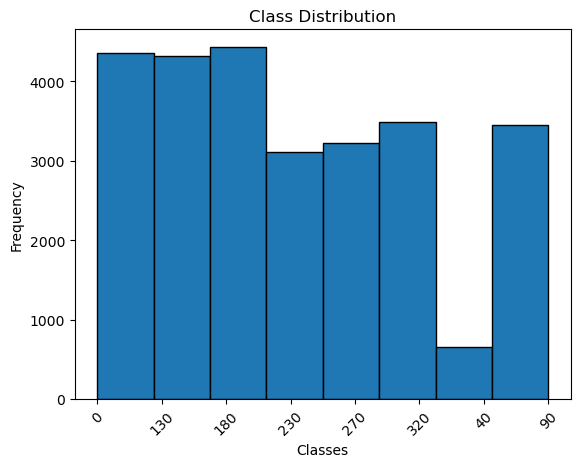

In [4]:
labels = dataset.targets

plt.hist(labels, bins=len(class_names), edgecolor="black")
plt.title("Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.show()

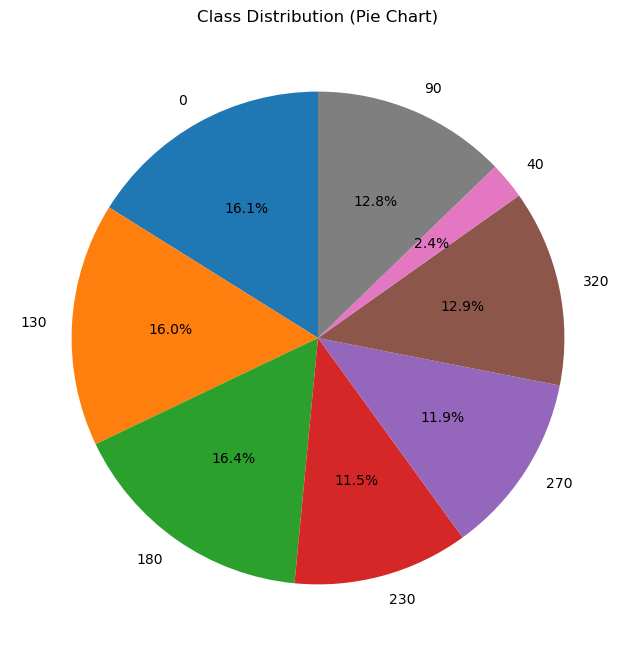

In [5]:
class_counts = np.bincount(labels)
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab10.colors)
plt.title("Class Distribution (Pie Chart)")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

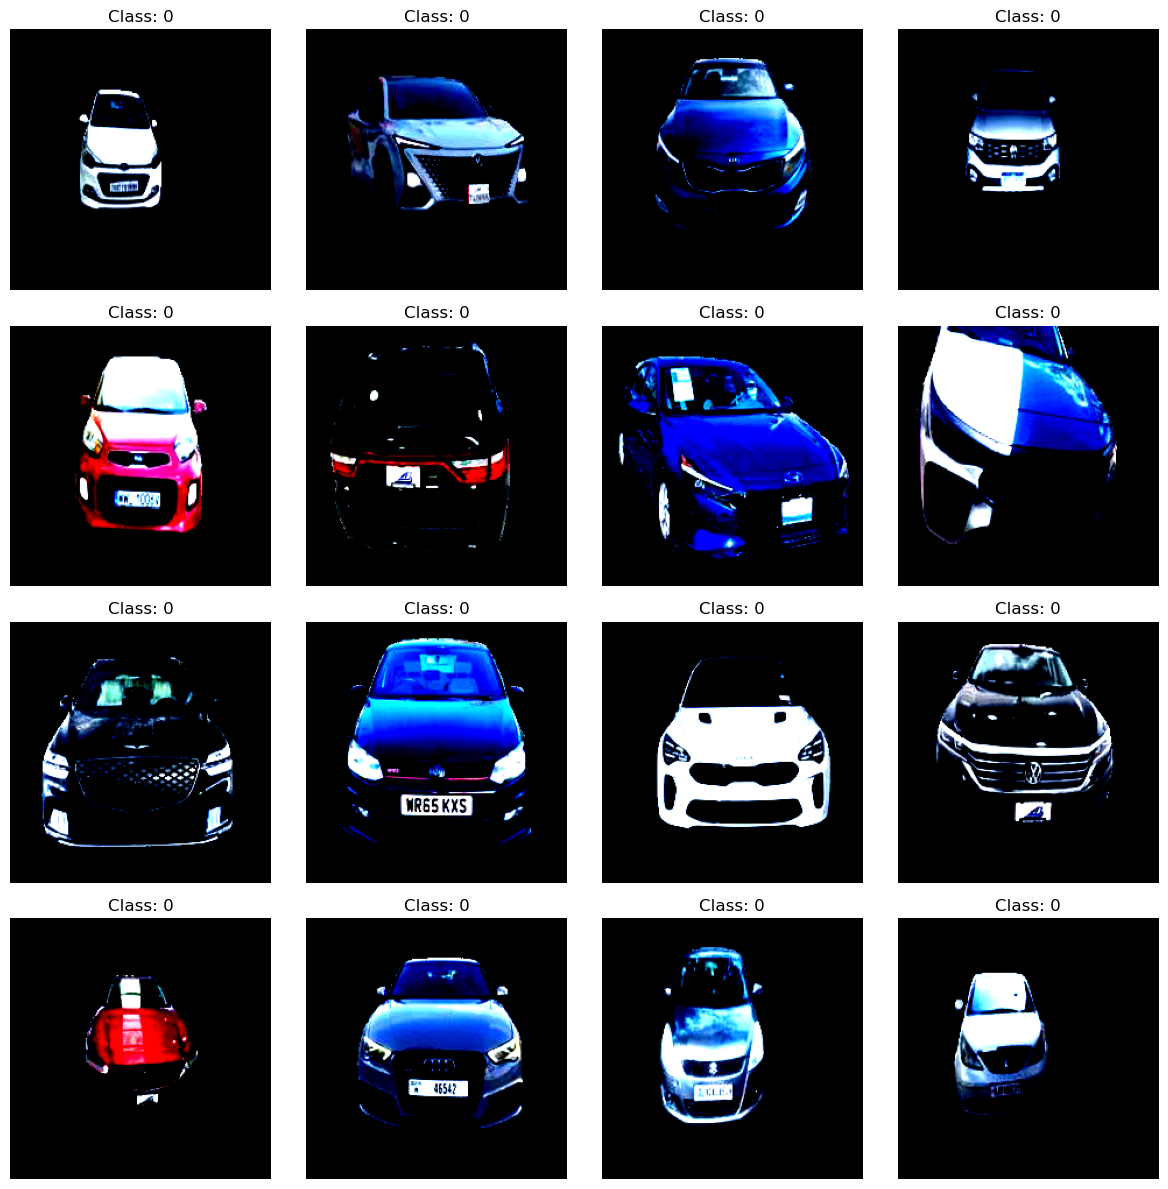

['0', '130', '180', '230', '270', '320', '40', '90']

In [6]:
def plot_sample_images(dataset, class_names, num_samples=4):
    fig, axes = plt.subplots(num_samples, num_samples, figsize=(12, 12))
    for i in range(num_samples * num_samples):
        image, label = dataset[i]
        ax = axes[i // num_samples, i % num_samples]
        ax.imshow(image.permute(1, 2, 0))  # Convert CHW to HWC for matplotlib
        ax.set_title(f"Class: {class_names[label]}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_sample_images(dataset, class_names)
class_names

In [7]:
from torchvision.models import efficientnet_b0

def get_efficientnet_model(num_classes):
    """
    Returns a pre-trained EfficientNet model with a modified classifier head for classification.
    """
    model = efficientnet_b0(pretrained=True)
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model.to(device)

model = get_efficientnet_model(num_classes=len(class_names))

c:\Users\utkar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\utkar\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
def train(model, dataloader, criterion, optimizer):
    """
    Train the model for one epoch with tqdm progress bar and time tracking.

    Args:
        model: The PyTorch model to train.
        dataloader: DataLoader for the training data.
        criterion: Loss function.
        optimizer: Optimizer.

    Returns:
        epoch_loss: Average loss for the epoch.
        epoch_acc: Accuracy for the epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    with tqdm(total=len(dataloader), desc="Training", unit="batch") as pbar:
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.update(1)

    end_time = time.time()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total

    print(f"Epoch completed in {end_time - start_time:.2f}s")
    return epoch_loss, epoch_acc

In [10]:
def evaluate(model, dataloader, criterion):
    """
    Evaluate the model on a validation or test dataset with tqdm and time tracking.

    Args:
        model: The PyTorch model to evaluate.
        dataloader: DataLoader for the validation or test data.
        criterion: Loss function.

    Returns:
        epoch_loss: Average loss for the dataset.
        epoch_acc: Accuracy for the dataset.
        f1: Weighted F1 score for the dataset.
        all_labels: Ground truth labels.
        all_predictions: Predicted labels.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    start_time = time.time()

    with tqdm(total=len(dataloader), desc="Evaluating", unit="batch") as pbar:
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

                pbar.update(1)

    end_time = time.time()
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Evaluation completed in {end_time - start_time:.2f}s")
    return epoch_loss, epoch_acc, f1, all_labels, all_predictions

In [11]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
f1_scores = []


In [12]:
import torch

best_f1_score = 0.0
best_model_path = "best_model.pth"

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
f1_scores = []

start_time = time.time()
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, f1, _, _ = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    f1_scores.append(f1)

    scheduler.step()

    if f1 > best_f1_score:
        best_f1_score = f1
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch + 1} with F1 Score: {f1:.4f}")

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, F1 Score: {f1:.4f}")

total_training_time = time.time() - start_time
print(f"Training completed in {total_training_time // 60:.0f}m {total_training_time % 60:.0f}s")
print("Loading the best model for testing...")
model.load_state_dict(torch.load(best_model_path))


Epoch 1/10


Training: 100%|██████████| 592/592 [02:40<00:00,  3.69batch/s]


Epoch completed in 160.59s


Evaluating: 100%|██████████| 127/127 [00:30<00:00,  4.23batch/s]


Evaluation completed in 30.02s
Best model saved at epoch 1 with F1 Score: 0.9557
Train Loss: 0.2644, Train Acc: 0.9218
Val Loss: 0.1523, Val Acc: 0.9556, F1 Score: 0.9557
Epoch 2/10


Training: 100%|██████████| 592/592 [02:09<00:00,  4.58batch/s]


Epoch completed in 129.36s


Evaluating: 100%|██████████| 127/127 [00:22<00:00,  5.73batch/s]


Evaluation completed in 22.17s
Best model saved at epoch 2 with F1 Score: 0.9598
Train Loss: 0.1595, Train Acc: 0.9521
Val Loss: 0.1506, Val Acc: 0.9598, F1 Score: 0.9598
Epoch 3/10


Training: 100%|██████████| 592/592 [01:57<00:00,  5.04batch/s]


Epoch completed in 117.40s


Evaluating: 100%|██████████| 127/127 [00:11<00:00, 10.89batch/s]


Evaluation completed in 11.66s
Train Loss: 0.1345, Train Acc: 0.9591
Val Loss: 0.1727, Val Acc: 0.9475, F1 Score: 0.9475
Epoch 4/10


Training: 100%|██████████| 592/592 [01:33<00:00,  6.31batch/s]


Epoch completed in 93.80s


Evaluating: 100%|██████████| 127/127 [00:10<00:00, 12.40batch/s]


Evaluation completed in 10.24s
Train Loss: 0.1096, Train Acc: 0.9652
Val Loss: 0.1831, Val Acc: 0.9559, F1 Score: 0.9559
Epoch 5/10


Training: 100%|██████████| 592/592 [01:34<00:00,  6.27batch/s]


Epoch completed in 94.47s


Evaluating: 100%|██████████| 127/127 [00:11<00:00, 11.32batch/s]


Evaluation completed in 11.22s
Train Loss: 0.1002, Train Acc: 0.9673
Val Loss: 0.1636, Val Acc: 0.9561, F1 Score: 0.9561
Epoch 6/10


Training: 100%|██████████| 592/592 [01:37<00:00,  6.05batch/s]


Epoch completed in 97.79s


Evaluating: 100%|██████████| 127/127 [00:10<00:00, 11.55batch/s]


Evaluation completed in 11.00s
Train Loss: 0.0783, Train Acc: 0.9750
Val Loss: 0.1989, Val Acc: 0.9485, F1 Score: 0.9484
Epoch 7/10


Training: 100%|██████████| 592/592 [01:37<00:00,  6.10batch/s]


Epoch completed in 97.13s


Evaluating: 100%|██████████| 127/127 [00:11<00:00, 11.47batch/s]


Evaluation completed in 11.08s
Train Loss: 0.0692, Train Acc: 0.9766
Val Loss: 0.2206, Val Acc: 0.9448, F1 Score: 0.9447
Epoch 8/10


Training: 100%|██████████| 592/592 [01:37<00:00,  6.09batch/s]


Epoch completed in 97.28s


Evaluating: 100%|██████████| 127/127 [00:10<00:00, 11.85batch/s]


Evaluation completed in 10.72s
Train Loss: 0.0269, Train Acc: 0.9906
Val Loss: 0.2032, Val Acc: 0.9576, F1 Score: 0.9576
Epoch 9/10


Training: 100%|██████████| 592/592 [01:36<00:00,  6.11batch/s]


Epoch completed in 96.83s


Evaluating: 100%|██████████| 127/127 [00:10<00:00, 11.83batch/s]


Evaluation completed in 10.73s
Train Loss: 0.0109, Train Acc: 0.9969
Val Loss: 0.2289, Val Acc: 0.9573, F1 Score: 0.9574
Epoch 10/10


Training: 100%|██████████| 592/592 [01:37<00:00,  6.09batch/s]


Epoch completed in 97.17s


Evaluating: 100%|██████████| 127/127 [00:10<00:00, 11.98batch/s]
C:\Users\utkar\AppData\Local\Temp\ipykernel_25544\1132969725.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental featu

Evaluation completed in 10.60s
Train Loss: 0.0074, Train Acc: 0.9980
Val Loss: 0.2410, Val Acc: 0.9561, F1 Score: 0.9561
Training completed in 20m 21s
Loading the best model for testing...


<All keys matched successfully>

In [13]:
test_loss, test_acc, test_f1, test_labels, test_predictions = evaluate(model, test_loader, criterion)

print("Test Accuracy: {:.4f}".format(test_acc))
print("Test F1 Score: {:.4f}".format(test_f1))
print("Classification Report:\n", classification_report(test_labels, test_predictions, target_names=class_names))

Evaluating: 100%|██████████| 127/127 [00:31<00:00,  4.07batch/s]

Evaluation completed in 31.18s
Test Accuracy: 0.9581
Test F1 Score: 0.9581
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       634
         130       0.98      0.96      0.97       627
         180       0.92      0.95      0.93       677
         230       0.98      0.97      0.97       472
         270       0.99      0.98      0.99       464
         320       0.96      0.98      0.97       539
          40       0.88      0.91      0.90       103
          90       0.98      0.99      0.98       541

    accuracy                           0.96      4057
   macro avg       0.95      0.96      0.95      4057
weighted avg       0.96      0.96      0.96      4057



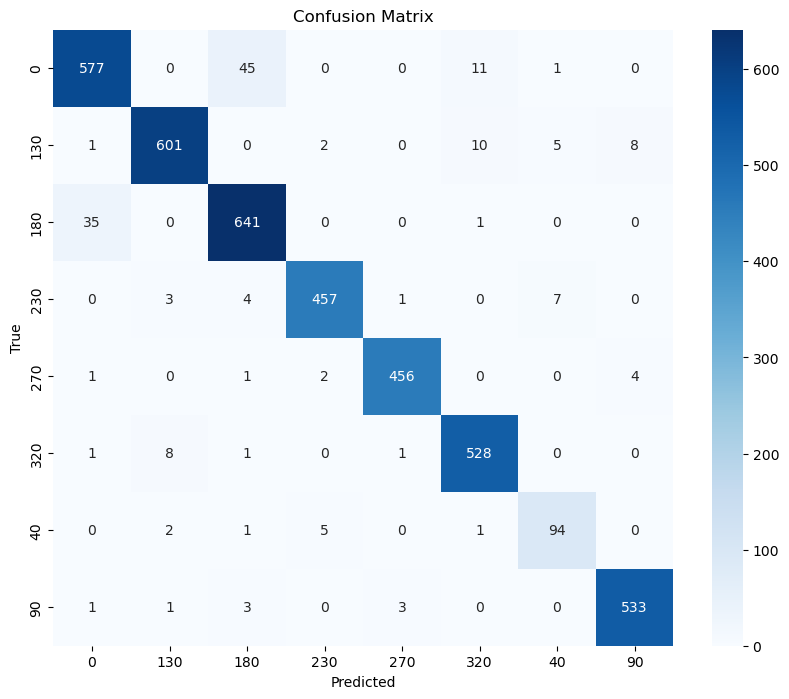

In [14]:
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

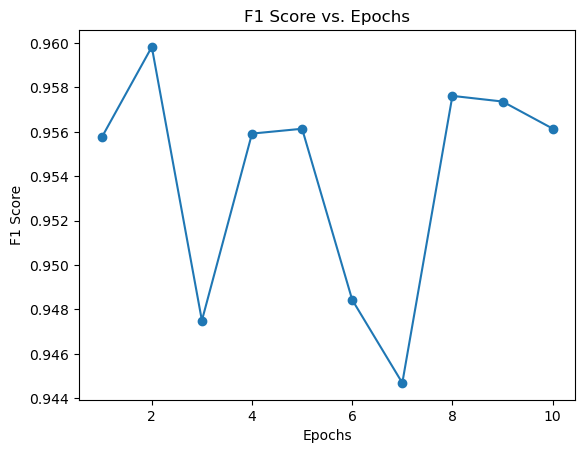

In [15]:
plt.plot(range(1, num_epochs + 1), f1_scores, marker='o')
plt.title("F1 Score vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.show()

In [14]:
!pip3 uninstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124


Usage:   
  pip3 uninstall [options] <package> ...
  pip3 uninstall [options] -r <requirements file> ...

no such option: --index-url
